# To Do
* test prism_layer difference if input .nc grids are pixle registered instead of gridline registered
* add actual grav observation elevations
* check bedmap1 riggs points are reference to WGS
* recalculate all bedmachine grids relatvie to WGS
* replace "reversed_layer_list" with 
    * ind = layers_list.index(active_layer)
    * layers[layers_list[ind-1]
* test replacing grav_col_der with adding small prisms approx.
* fix forward grav with different resolutions
* fix geo inversion with different resolutions
* use discretize package to increase grid spacing outside of inv_reg
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

In [3]:
# The standard Python science stack
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import lsqr
# geoscience packages
import pygmt
import pyproj
import pyvista as pv
import geopandas as gpd
import harmonica as hm
import verde as vd
import xarray as xr
from tqdm import tqdm
import rioxarray
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', message="pandas.Int64Index")
warnings.filterwarnings('ignore', message="pandas.Float64Index")
from scripts.gravbox import * 
from scripts.grav_column_der import grav_column_der

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()

'c:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_gravity_inversion'

# Functions

In [4]:
def plot_grd(
        grid, 
        cmap : str, 
        cbar_label : str, 
        plot_region=None, 
        cmap_region=None, 
        coast=False,
        constraints=False,
        grd2cpt_name=False, 
        origin_shift='initialize',
        ):
    global fig, projection
    if plot_region is None:
        plot_region = inv_reg
    if cmap_region is None:
        cmap_region = inv_reg
    if plot_region == buffer_reg:
        projection = buffer_proj
    elif plot_region == inv_reg:
        projection = inv_proj
    # initialize figure or shift for new subplot
    if origin_shift=='initialize':
        fig = pygmt.Figure()   
    elif origin_shift=='xshift':
        fig.shift_origin(xshift=(fig_width + 2)/10)
    elif origin_shift=='yshift':
        fig.shift_origin(yshift=(fig_height + 12)/10)

    # set cmap
    if grd2cpt_name:
        pygmt.grd2cpt(
            cmap=cmap, 
            grid=grid, 
            region=cmap_region, 
            background=True, 
            continuous=True,
            output=f'plotting/{grd2cpt_name}.cpt')
        cmap = f'plotting/{grd2cpt_name}.cpt'

    fig.grdimage(
        grid=grid,
        cmap=cmap,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])

    fig.colorbar(
        cmap=cmap, 
        position='jBC+jTC+h', 
        frame=f'x+l"{cbar_label}"')

    if coast==True:
        fig.plot(
                projection = projection, 
                region = plot_region,
                data = gpd.read_file('plotting/GroundingLine_Antarctica_v02.shp'), 
                pen = '1.2p,black', 
                verbose='q',)

    fig.plot(data = gpd.read_file('plotting/Coastline_Antarctica_v02.shp'), 
            pen = '1.2p,black',
            verbose='q',
            )
    if constraints==True:
        fig.plot(
                x = constraints_RIS_df.x, 
                y = constraints_RIS_df.y, 
                style = 'c1.2p',
                color = 'black',
                projection = projection,
                region = plot_region,)

    if plot_region==buffer_reg:
        fig.plot(
            x = [inv_reg[0], inv_reg[0], inv_reg[1], inv_reg[1], inv_reg[0]], 
            y = [inv_reg[2], inv_reg[3], inv_reg[3], inv_reg[2], inv_reg[2]], 
            pen = '2p,black', 
            projection = projection,
            region = plot_region,)

def import_layers(
            layers_list, 
            spacing_list, 
            rho_list, 
            fname_list,
            grav_spacing, 
            active_layer,
            grav_file='gravity_data/ant4d_gravity_epsg_5k.nc',
            constraints_file='constraints_grid/constraints_grid.nc',
            constraints_points='bathymetry_data/bedmachine_RIGGS.csv'):
    global inv_reg, grid_grav, layers, df_grav, constraints_grid, constraints_df, constraints_RIS_df
    # read and resample gravity grid
    grid_grav = pygmt.grdsample(
                        grid=grav_file,
                        region=inv_reg, 
                        registration='p', 
                        spacing=grav_spacing,
                        # verbose='e',
                        )
    df_grav = grid_grav.to_dataframe().reset_index()
    df_grav.rename(columns={'z':'Gobs'}, inplace=True)
    df_grav.dropna(how='any', inplace=True)  
    # make nested dictionary for layers and properties
    layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}
    # read and resample layer grids, convert to dataframes
    for k, v in layers.items():
        v['grid'] = pygmt.grdsample(
                        grid=v['fname'],
                        region=buffer_reg, 
                        registration='p', 
                        spacing=v['spacing'],
                        # verbose='e',
                        )
        v['df'] = v['grid'].to_dataframe().reset_index()
        v['df']['rho']=v['rho']
        v['df'].dropna(how='any', inplace=True)
        v['len']=len(v['df'].x) 
    # read and resample constraints grid, and mask outside of RIS
    constraints_grid = pygmt.grdsample(
                        grid=constraints_file,
                        region=buffer_reg, 
                        registration='p', 
                        spacing=spacing_list[layers_list.index(active_layer)],
                        # verbose='e',
                        )
    fname = 'bathymetry_data/bedmachine_RIGGS.csv'
    constraints_df =  pd.read_csv(fname, index_col=False)
    buffer_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
    # pygmt.clib.Session.call_module('grdmask', 'plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{buffer_reg_str} -NNaN/NaN/1')
    !gmt grdmask plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{buffer_reg_str} -NNaN/NaN/1
    constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')
    # add gravity elevation (approximated as 750m above surface)
    df_grav['z']=layers[layers_list[0]]['grid'].to_dataframe().reset_index().z+750 
    # df_grav['z']=0
    # print lengths
    for k, v in layers.items():
        print(f"{k}: {v['len']} points, elevations: {int(np.nanmax(v['grid']))}m to {int(np.nanmin(v['grid']))}m") 
    print(f'gravity: {len(df_grav)} points')    
    print(f'bathymetry control points:{len(constraints_df)}') 

def forward_grav_layers(layers, plot=True):
    global Gfor_grid
    # Calculate inital forward gravity model of input layer
    # add density variable to datasets
    for k ,v in layers.items():
        v['grid']['density']=v['grid'].copy()
        v['grid'].density.values[:] = v['rho']

    # list of layers, bottom up
    reversed_layers_list = np.flip(layers_list[:])

    for i, j in enumerate(reversed_layers_list):
        if i == 0:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'], 
                # reference=-50e3,
                reference = np.nanmin(layers[j]['grid'].values)*2, # bottom of prisms is twice the deepest depth
                properties={'density':layers[j]['grid'].density})
            print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')

        else:
            # if spacing of layer doesn't match below layer's spacing, sample lower layer to get values for bottoms of prisms.
            if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
                print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
                print(f"sampling {reversed_layers_list[i-1]} at {j} prism locations")
                tmp = layers[j]['grid'].to_dataframe().reset_index()
                tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                            grid = layers[reversed_layers_list[i-1]]['grid'], 
                                            newcolname = 'z_regrid')
                tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
                tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = buffer_reg, registration='p', spacing = layers[j]['spacing'])

                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'], 
                    reference=tmp_grd,
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')
            else:
                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                    surface=layers[j]['grid'], 
                    reference=layers[reversed_layers_list[i-1]]['grid'],
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {np.nanmean(layers[j]["prisms"].top.values)}m and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}m')

    print('starting forward gravity calculations and gridding')
    for k, v in layers.items():
        df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
        print(f'finished {k} layer')
        layers[k]['forward_grav'] = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                            region=inv_reg, spacing=grav_spacing, registration='p', projection=inv_proj) 

    # add gravity effects of all input layers
    grav_layers_list = [f'{x}_forward_grav' for x in layers_list]
    df_grav['forward_grav_total']=df_grav[grav_layers_list].sum(axis=1)
    
    # grid results 
    Gfor_grid = pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                    region=inv_reg, 
                                    spacing=grav_spacing,
                                    registration='p', 
                                    projection=inv_proj)
    if plot==True:
        plot_grd(
            # plot_region=buffer_reg,
            grid=Gfor_grid,
            cmap='jet',
            grd2cpt_name='grav',
            cbar_label = f"combined forward gravity (mGal)",)

        for i, (k, v) in enumerate(layers.items()):
            plot_grd(
                # plot_region=buffer_reg,
                grid=v['forward_grav'], 
                cmap = 'jet',
                grd2cpt_name = 'grav',
                cbar_label = f"{k} forward gravity (mGal)",
                origin_shift='xshift',)
            
        fig.show(width=1200)
    # return Gfor_grid, df_grav, layers  

def anomalies(layers, filter='g200e3', plot=True,):  
    forward_grav_layers(layers=layers, plot=False)

    Gobs_misfit = grid_grav - Gfor_grid 
    
    # sample Gobs_misift at constraint points
    tmp_regrid = pygmt.grdtrack(points = constraints_RIS_df[['x','y']], 
                                grid = Gobs_misfit, newcolname = 'Gmisfit_sampled')
    constraints_RIS_df['Gmisfit']=constraints_RIS_df.merge(tmp_regrid, how = 'left', on = ['x','y']).Gmisfit_sampled
    shift = constraints_RIS_df.Gmisfit.mean()
    # df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
    # shift = df_grav.initial_misfit.mean() 
    print(f'initial misfit at control points is {int(shift)} mGal')

    df_grav['Gobs_shift'] = df_grav.Gobs - shift
    print(f'average Gobs_shifted: {int(df_grav.Gobs_shift.mean())} mGal')

    df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total
    misfit_shift = df_grav.forward_grav_misfit.mean() 
    print(f'misfit between Gobs_shift and forward gravity is {misfit_shift} mGal')

    # make grids of anomalies
    Gobs_shift_grid = pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                    region=inv_reg, 
                                    spacing=grav_spacing,
                                    registration='p', 
                                    projection=inv_proj)

    Gmisfit_grid = pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                    region=inv_reg, 
                                    spacing=grav_spacing,
                                    registration='p', 
                                    projection=inv_proj)

    Gobs_shift_filt_grid = pygmt.grdfilter(Gobs_shift_grid, filter=filter, distance='0')

    Gmisfit_filt_grid = Gobs_shift_filt_grid - Gfor_grid 



    # add to dataframe
    # do these need to be transposed??
    df_grav['Gobs_shift_filt'] = Gobs_shift_filt_grid.to_dataframe().reset_index().z
    df_grav['Gmisfit_filt'] = Gmisfit_filt_grid.transpose().to_dataframe().reset_index().z
    # df_grav['Gobs_constraints'] = Gobs_constraints_grid.transpose().to_dataframe().reset_index().z
    # df_grav['Gmisfit_constraints'] = Gmisfit_constraints_grid.transpose().to_dataframe().reset_index().z

    if plot==True:
        grid = Gobs_shift_grid
        plot_grd(grid=grid, cmap='jet', grd2cpt_name='grav',
            cbar_label = "observed gravity (mGal)",)

        # grid = Gobs_constraints_grid
        # plot_grd(grid=grid, cmap='jet', grd2cpt_name='grav', 
        #     cbar_label = "regional gravity (mGal)", origin_shift='xshift',)

        grid = Gobs_shift_filt_grid
        plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
            cbar_label = "filtered observed gravity (mGal)", origin_shift='xshift',)

        grid = Gfor_grid
        plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
            cbar_label = "forward gravity (mGal)", origin_shift='xshift',)

        grid = Gmisfit_grid
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
            cbar_label = "gravity misfit (mGal)", origin_shift='xshift',)

        # grid = Gmisfit_constraints_grid
        # plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
        #     cbar_label = "regional gravity misfit (mGal)", origin_shift='xshift',)
        
        grid = Gmisfit_filt_grid
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
            cbar_label = "regional gravity misfit (mGal)", origin_shift='xshift',)
            
        fig.show(width=1200) 

def density_inversion(density_layer, max_density_change=2000,  input_grav=None, plot=True):    
    if input_grav is None:
        input_grav=df_grav.Gobs_shift_filt
    # density in kg/m3
    forward_grav_layers(layers=layers, plot=False)
    spacing = layers[density_layer]['spacing']

    # df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total']
    df_grav['inv_misfit']=input_grav - df_grav[f'forward_grav_total']

    # get prisms' coordinates from active layer
    prisms = layers[density_layer]['prisms'].to_dataframe().reset_index().dropna()

    print(f'active layer average density: {int(prisms.density.mean())}kg/m3')

    MAT_DENS = (np.zeros([len(input_grav),len(prisms)]))

    initial_RMS = round(np.sqrt((df_grav['inv_misfit'] **2).mean()),2)
    print(f"initial RMS = {initial_RMS}mGal")
    print('calculating sensitivity matrix to determine density correction')

    prisms_n=[]
    for x in range(len(layers[density_layer]['prisms'].easting.values)):
        for y in range(len(layers[density_layer]['prisms'].northing.values)):
            prisms_n.append(layers[density_layer]['prisms'].prism_layer.get_prism((x,y)))
    for col, prism in enumerate(prisms_n):
        MAT_DENS[:, col] = hm.prism_gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            prisms = prism,
            density = 1, # unit density
            field = 'g_z',)
    # Calculate shift to prism's densities to minimize misfit     
    Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]

    # for i,j in enumerate((input_grav)): #add tqdm for progressbar
    #         MAT_DENS[i,:] = gravbox(
    #                             df_grav.y.iloc[i], df_grav.x.iloc[i], df_grav.z.iloc[i],
    #                             prisms.northing-spacing/2, prisms.northing+spacing/2,
    #                             prisms.easting-spacing/2, prisms.easting+spacing/2,
    #                             prisms.top,  prisms.bottom, np.ones_like(prisms.density))  # unit density, list of ones
    # # Calculate shift to prism's densities to minimize misfit     
    # Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]*1000

    # apply max density change
    for i in range(0,len(prisms)):
        if Density_correction[i] > max_density_change:
            Density_correction[i]=max_density_change
        elif Density_correction[i] < -max_density_change:
            Density_correction[i]=-max_density_change

    # resetting the rho values with the above correction
    prisms['density_correction']=Density_correction
    prisms['updated_density']=prisms.density+prisms.density_correction
    dens_correction = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.density_correction, registration='p', 
                    region=buffer_reg, spacing=grav_spacing, projection=buffer_proj)
    dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.updated_density, registration='p', 
                    region=buffer_reg, spacing=layers[density_layer]['spacing'], projection=buffer_proj)
    initial_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing, registration='p')

    # apply the rho correction to the prism layer
    layers[density_layer]['prisms']['density'].values=dens_update.values
    print(f"average density: {int(layers[density_layer]['prisms'].to_dataframe().reset_index().dropna().density.mean())}kg/m3")
    # recalculate forward gravity of active layer               
    print('calculating updated forward gravity')
    df_grav[f'forward_grav_{density_layer}'] = layers[density_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')

    # Recalculate of gravity misfit, i.e., the difference between calculated and observed gravity
    df_grav['forward_grav_total'] = df_grav.forward_grav_total - \
                                    df_grav[f'{density_layer}_forward_grav'] + \
                                    df_grav[f'forward_grav_{density_layer}']
                                    
    df_grav.inv_misfit = input_grav - df_grav.forward_grav_total
    final_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
    print(f"RMSE after inversion = {final_RMS}mGal")
    final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=buffer_reg, registration='p', spacing=grav_spacing)

    if plot==True:
        grid = initial_misfit
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
            cbar_label = f"initial misfit (mGal) [{initial_RMS}]")

        grid = dens_correction
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='dens_corr',
            cbar_label = "density correction (kg/m3)", origin_shift='xshift')

        grid = dens_update
        plot_grd(grid=grid, cmap='viridis', grd2cpt_name='dens_update',
            cbar_label = "updated density (kg/m3)", origin_shift='xshift')

        grid = final_misfit
        plot_grd(grid=grid, cmap='polar+h0',# grd2cpt_name='misfit',
            cbar_label = f"final misfit (mGal) [{final_RMS}]", origin_shift='xshift')

        fig.show(width=1200)

def geo_inversion(
    constraints, 
    active_layer,
    input_grav = None, 
    misfit_sq_tolerance=0.00001,
    delta_misfit_squared_tolerance=0.002,
    Max_Iterations=5,
    max_layer_change_per_iter=100, #meters
    plot=True):

    if input_grav is None:
        input_grav = df_grav.Gobs_shift

    forward_grav_layers(layers=layers, plot=False)
    prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
    df_grav['inv_misfit'] = input_grav - df_grav.forward_grav_total
    spacing = layers[active_layer]['spacing'] 
    misfit_squared_updated=np.Inf  # positive infinity
    delta_misfit_squared=np.Inf  # positive infinity

    ITER=0
    # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
    while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
        ITER+=1 
        print(f"##################################\n iteration {ITER}")
        # get prisms' coordinates from active layer and layer above
        prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
        ind = layers_list.index(active_layer)
        prisms_above = layers[layers_list[ind-1]]['prisms'].to_dataframe().reset_index().dropna()
        print(f'active layer average depth: {int(prisms.top.mean())}m')

        # calculate jacobian with grav_column_der
        jacobian = (np.zeros([len(input_grav),len(prisms)]))
        initial_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
        print(f"initial RMS = {initial_RMS}mGal")
        # print('calculating Jacobian matrix to determine surface correction')
        for i,j in enumerate((input_grav)):
            # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
            #jacobian is matrix array with NG number of rows and NBath+NBase+NM number of columns
            # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
            jacobian[i,:]=grav_column_der(
                                        df_grav.y.iloc[i], # coords of gravity observation points
                                        df_grav.x.iloc[i],
                                        df_grav.z.iloc[i],  
                                        prisms.northing, prisms.easting,     
                                        prisms.top, 
                                        prisms.bottom,
                                        spacing,     
                                        prisms.density/1000)  # jacobian[i,0:NBath] is i'th row and columns 0 to NBath
        # Calculate shift to prism's tops to minimize misfit
        # gives the amount that each column's Z1 needs to change by to have the smallest misfit
        Surface_correction=lsqr(jacobian,df_grav.inv_misfit,show=False)[0] # finds the least-squares solution to jacobian and Grav_Misfit, assigns the first value to Surface_correction

        # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
        for i in range(0,len(prisms)):
            if Surface_correction[i] > max_layer_change_per_iter:
                Surface_correction[i]=max_layer_change_per_iter
            elif Surface_correction[i] < -max_layer_change_per_iter:
                Surface_correction[i]=-max_layer_change_per_iter
        prisms['surface_correction']=Surface_correction
        prisms_above['surface_correction']=Surface_correction

        # add constraints to dataframe
        prisms['constraints']=constraints_grid.to_dataframe().reset_index().z
        prisms_above['constraints']=constraints_grid.to_dataframe().reset_index().z
        
        # apply above surface corrections 
        if constraints==True:
            prisms.top += prisms.surface_correction * prisms.constraints
            prisms_above.bottom += prisms_above.surface_correction * prisms_above.constraints
        else:
            print('constraints not applied')
            prisms.top += prisms.surface_correction
            prisms_above.bottom += prisms_above.surface_correction

        # apply the z correction to the active prism layer and the above layer with Harmonica 
        prisms_grid = pygmt.xyz2grd(prisms[['easting','northing','top']],region=buffer_reg, registration='p', spacing=spacing)
        prisms_above_grid = pygmt.xyz2grd(prisms_above[['easting','northing','bottom']], region=buffer_reg, registration='p', spacing=spacing)
        layers[active_layer]['prisms'].prism_layer.update_top_bottom(
                        surface = prisms_grid, 
                        reference = layers[active_layer]['prisms'].bottom)
        layers[layers_list[ind-1]]['prisms'].prism_layer.update_top_bottom(
                        surface = layers[layers_list[ind-1]]['prisms'].top, 
                        reference = prisms_above_grid)
        
        initial_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=buffer_reg, registration='p', spacing=grav_spacing)
        iter_corr = pygmt.xyz2grd(
            x=prisms.easting,y=prisms.northing, z=prisms.surface_correction, region=buffer_reg, registration='p', spacing=spacing)
        iter_corr_constrained = pygmt.xyz2grd(
            x=prisms.easting,y=prisms.northing, z=prisms.surface_correction*prisms.constraints, region=buffer_reg, registration='p', spacing=spacing)
        
        print('calculating updated forward gravity')
        df_grav[f'{active_layer}_forward_grav'] = layers[active_layer]['prisms'].prism_layer.gravity(
                coordinates=(df_grav.x, df_grav.y, df_grav.z),
                field = 'g_z')
        df_grav[f'{layers_list[ind-1]}_forward_grav'] = layers[layers_list[ind-1]]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')

        # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
        # replace previous forward grav of layer with newly calculated forward grav
        # df_grav.forward_grav_total += \
        #                 (df_grav[f'{active_layer}_forward_grav'] - \
        #                 df_grav[f'{layers_list[ind-1]}_forward_grav'] + \
        #                 df_grav[f'forward_grav_{active_layer}']  + \
        #                 df_grav[f'forward_grav_{layers_list[ind-1]}'])
        for i, j in enumerate(layers_list):
            if i == 0:
                df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
            else:
                df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

        df_grav['inv_misfit'] = input_grav - df_grav.forward_grav_total
        final_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
        print(f"RMSE after iteration {ITER} = {final_RMS}mGal")
        # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
        misfit_sq=np.mean(df_grav.inv_misfit**2)
        delta_misfit_squared=misfit_squared_updated/misfit_sq
        misfit_squared_updated=misfit_sq # updated 
        layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=buffer_reg, registration='p', spacing=spacing)
        
        final_Gfor = pygmt.xyz2grd(df_grav[['x','y','forward_grav_total']], region=buffer_reg, registration='p', spacing=grav_spacing)
        final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=buffer_reg, registration='p', spacing=grav_spacing)
        difference = layers[active_layer]['inv_grid'] - layers[active_layer]['grid']

        if plot==True:
            grid = initial_misfit
            if ITER ==1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
                    cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='initialize')
            else:
                plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                    cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='yshift')

            grid=layers[active_layer]['inv_grid']
            plot_grd(grid=grid, cmap='globe',
                cbar_label = "updated bathymetry (m)", origin_shift='xshift')

            grid = iter_corr
            if ITER == 1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='corr',
                    cbar_label = "iteration correction (m)", origin_shift='xshift')
            else:
                plot_grd(grid=grid, cmap='plotting/corr.cpt',
                    cbar_label = "iteration correction (m)", origin_shift='xshift')

            grid = difference 
            if ITER ==1:
                plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='diff',
                    cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')
            else:
                plot_grd(grid=grid, cmap='plotting/diff.cpt',
                    cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')

            grid = final_misfit
            plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                cbar_label = f"final gravity misfit (mGal) [{final_RMS}]", origin_shift='xshift')
        
            # plot iteration label
            fig.shift_origin(xshift=((fig_width)/10))
            fig.text(projection = projection, 
                position='ML',
                justify='ML',
                text = f"It. #{ITER}",
                font = '30p,Helvetica,black',
                clearance = '+tO')
            fig.shift_origin(xshift=-((fig_width)/10))
            
            # shift back to origin 
            fig.shift_origin(xshift=-4*((fig_width + 2)/10))

            if ITER == Max_Iterations:
                print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
                break
            if misfit_sq < misfit_sq_tolerance:
                print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
                break

    fig.show(width=1200)

    # end of inversion iteration WHILE loop
    if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
        print("terminated - no significant variation in least-squares norm ")

In [5]:
zoom = 300e3
n_shift = 400e3
w_shift = 250e3
buffer = 300e3

# starting region is 1,000km x 1,000km
e_inv = -580000+zoom+w_shift
w_inv = 420000-zoom+w_shift
n_inv = -1420000+zoom-n_shift
s_inv = -420000-zoom-n_shift

inv_reg = [e_inv, w_inv, n_inv, s_inv]
e_buff, w_buff, n_buff, s_buff = int(e_inv-buffer), int(w_inv+buffer), int(n_inv-buffer), int(s_inv+buffer)
buffer_reg = [e_buff, w_buff, n_buff, s_buff]
buffer_reg_str=f'{e_buff}/{w_buff}/{n_buff}/{s_buff}'
inv_reg_ll = "-180/180/-90/-71"

fig_height = 80
fig_width = fig_height*(w_inv-e_inv)/(s_inv-n_inv)

inv_ratio = (s_inv-n_inv)/(fig_height/1000)
buffer_ratio = (s_buff-n_buff)/(fig_height/1000)

inv_proj = f"x1:{inv_ratio}"
buffer_proj = f"x1:{buffer_ratio}"

inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"
buffer_proj_ll = f"s0/-90/-71/1:{buffer_ratio}"

In [6]:
layers_list =[
             'ice',
             'water',
             'bathymetry',
             'basement',
             'moho'
]
spacing_list = [
                5e3,
                5e3,
                5e3,
                5e3,
                10e3
]
rho_list = [
            920,
            1030,
            2300,
            2800,
            3300
]
grav_spacing = 5e3

active_layer='bathymetry'

fname_list=[
        # SURFACE 
            'inversion_layers/bedmachine/BedMachine_surface_filled.nc',
        # ICEBASE
            'inversion_layers/bedmachine/BedMachine_icebase_filled.nc',
        # BED/BATHYMETRY
            'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
        # BASEMENT
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            'inversion_layers/RE_basement_BedMachinebed_filled.nc',
        # MOHO
            'inversion_layers/An_moho_filt.nc'
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc'
            ]

import_layers(
    layers_list, 
    spacing_list, 
    rho_list, 
    fname_list,
    grav_spacing, 
    active_layer,)

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


ice: 40000 points, elevations: 3570m to -97m
water: 40000 points, elevations: 3542m to -2821m
bathymetry: 40000 points, elevations: 3851m to -3848m
basement: 40000 points, elevations: 2906m to -8503m
moho: 10000 points, elevations: -8751m to -41514m
gravity: 6400 points
bathymetry control points:10475932


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


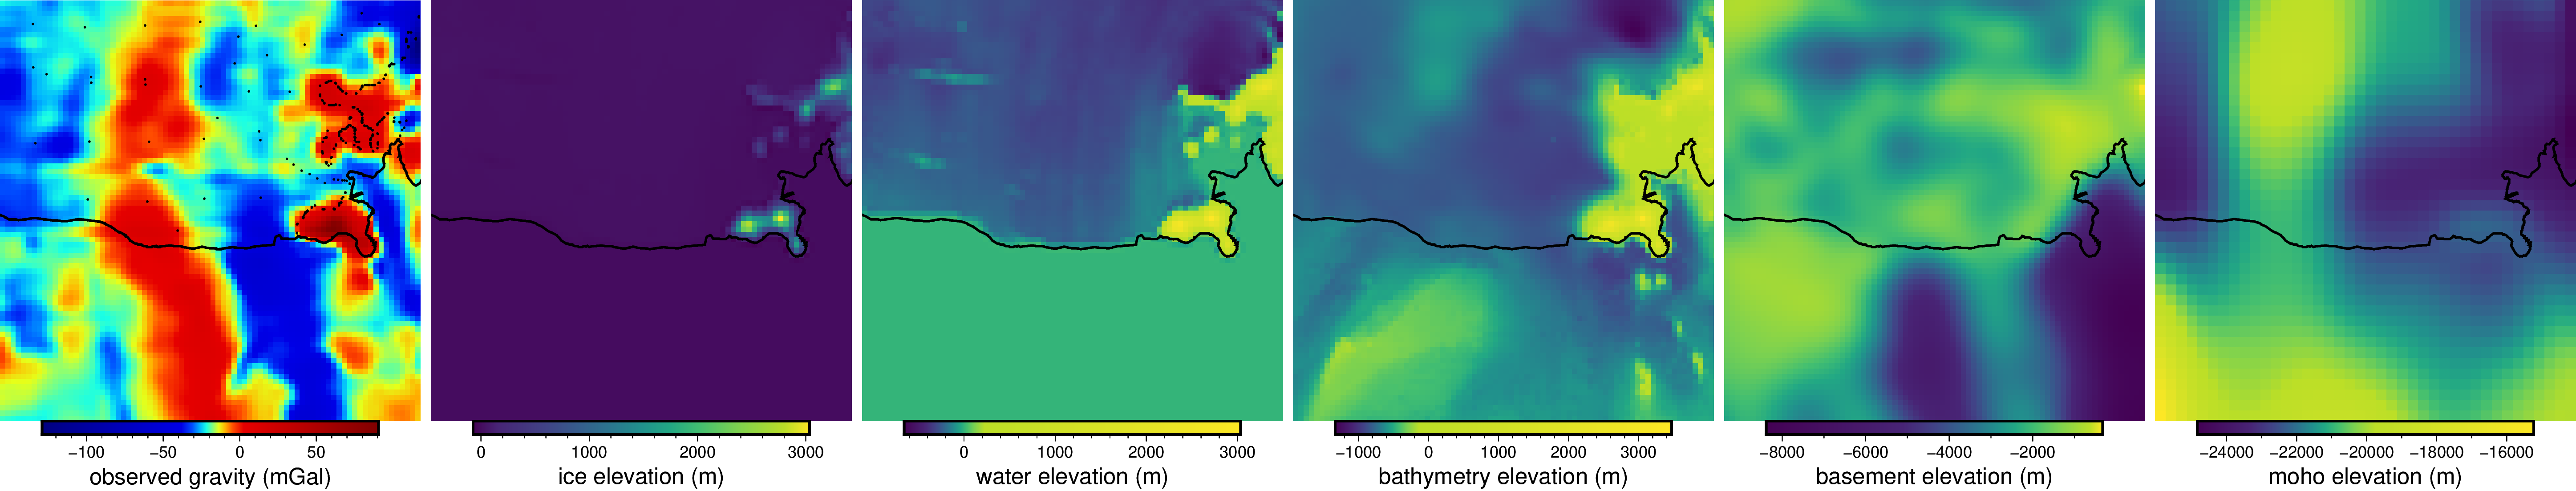

In [7]:
# get max and min of all layer grids
# max_list=[]
# min_list=[]
# for i, (k, v) in enumerate(layers.items()):
#     max_list.append(np.nanmax(v['grid']))
#     min_list.append(np.nanmin(v['grid']))

# pygmt.makecpt(cmap='earth+h0', series=[np.min(min_list)*.5, np.max(max_list)*.2], output='plotting/layer.cpt')

plot_grd(
    grid = grid_grav, 
    plot_region=inv_reg, 
    cmap = "jet",
    grd2cpt_name = 'grav',
    cbar_label = "observed gravity (mGal)", 
    constraints = True,    
    )

for i, (k, v) in enumerate(layers.items()):
    plot_grd(
        grid=layers[k]['grid'], 
        plot_region=inv_reg, 
        # cmap = "plotting/layer.cpt",
        cmap='viridis',
        grd2cpt_name = 'elevations',
        cbar_label = f"{k} elevation (m)",
        origin_shift='xshift',
        )

fig.show(width=1200)

moho top: -23636.28515625m and bottom: -83029.2734375m
resolutions don't match for basement (5000.0m) and moho (10000.0m)
sampling moho at basement prism locations
basement top: -2309.9111328125m and bottom: -23636.30859375m
bathymetry top: -375.86602783203125m and bottom: -2323.197998046875m
water top: 69.21922302246094m and bottom: -400.5728759765625m
ice top: 492.3894348144531m and bottom: 57.5244255065918m
starting forward gravity calculations and gridding
finished ice layer
finished water layer
finished bathymetry layer
finished basement layer
finished moho layer


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


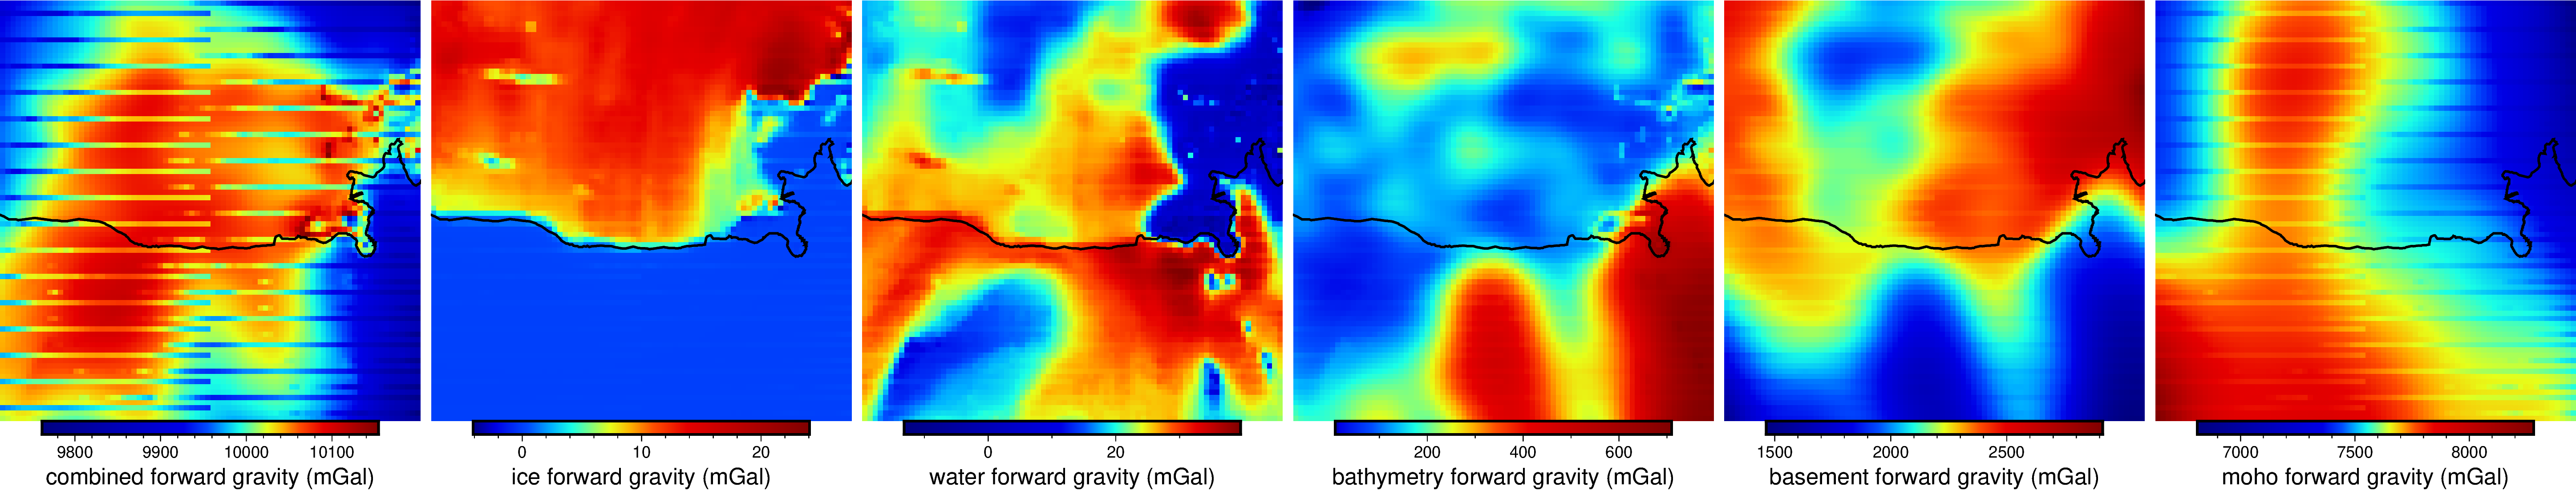

In [8]:
forward_grav_layers(layers, plot=True,)

In [11]:
prisms

<xarray.Dataset>
Dimensions:   (northing: 200, easting: 200)
Coordinates:
  * easting   (easting) float64 -3.275e+05 -3.225e+05 ... 6.625e+05 6.675e+05
  * northing  (northing) float64 -1.818e+06 -1.812e+06 ... -8.275e+05 -8.225e+05
    top       (northing, easting) float32 -3.848e+03 -3.839e+03 ... -389.0
    bottom    (northing, easting) float32 -4.668e+03 -4.665e+03 ... -397.5
Data variables:
    density   (northing, easting) float32 2.3e+03 2.3e+03 ... 2.3e+03 2.3e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


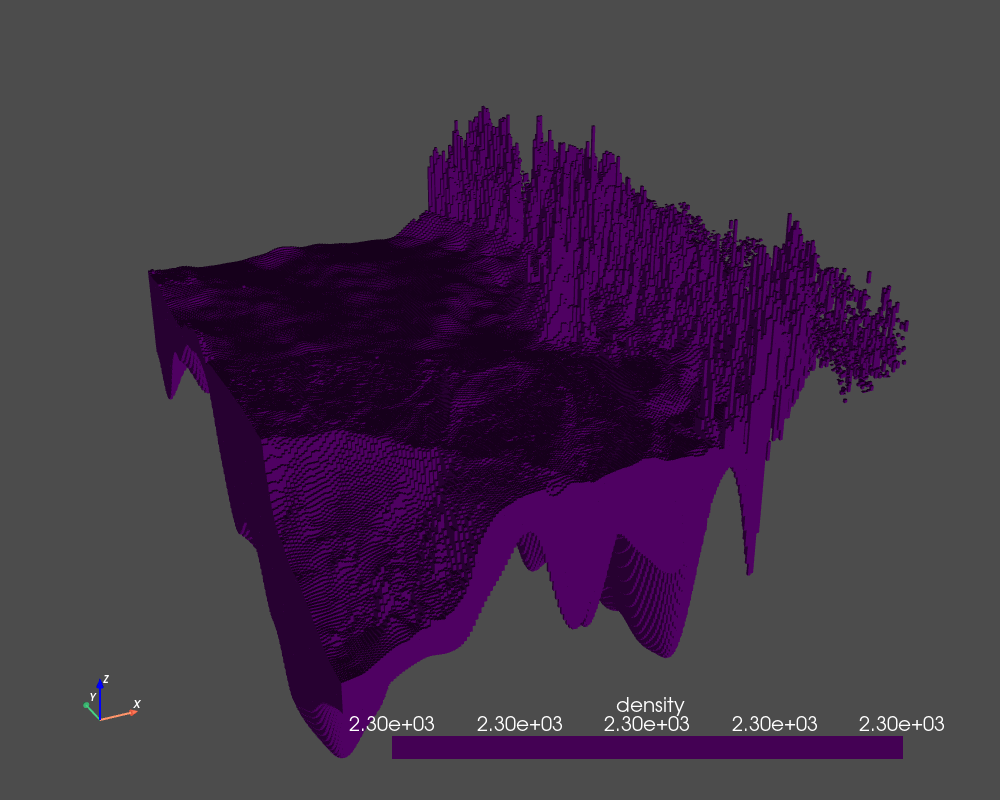

In [10]:
prisms=layers['bathymetry']['prisms']

# Create a pyvista UnstructuredGrid from the prism layer
pv_grid = prisms.prism_layer.to_pyvista()

# Plot with pyvista
plotter = pv.Plotter(lighting="three_lights", window_size=(1000, 800))
plotter.add_mesh(pv_grid, scalars="density")
plotter.set_scale(zscale=75)  # exaggerate the vertical coordinate
plotter.camera_position = "xz"
plotter.camera.elevation = 30
plotter.camera.azimuth = -25
plotter.camera.zoom(1.2)

# Add a ceiling light
west, east, south, north = vd.get_region((prisms.easting, prisms.northing))
easting_center, northing_center = (east + west) / 2, (north + south) / 2
light = pv.Light(
    position=(easting_center, northing_center, 10e3),
    focal_point=(easting_center, northing_center, 0),
    intensity=0.3,
    light_type="scene light",  # the light doesn't move with the camera
    positional=False,  # the light comes from infinity
)
plotter.add_light(light)

plotter.show_axes()
plotter.show()

In [ ]:
anomalies(layers=layers, plot=True, filter='g200e3')

In [ ]:
geo_inversion(
    constraints=False, 
    active_layer=active_layer,    
    Max_Iterations=3,
    max_layer_change_per_iter=100,
    ) 
# 15 mins 200km zoom/5k, 7mins 400kmzoom/5k (113x113 prisms, 33x33 grav)
# notify

In [ ]:
# density_inversion(density_layer='bathymetry', plot=True) #10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify